# Политическая кухня (10)

Задача предоставлена партнером олимпиады — Федеральным исследовательским центром "Информатика и управление" РАН

На некотором несуществующем интернет-ресурсе "Политическая кухня" популярностью пользуются два вида видеороликов: про политику и про кулинарию. При этом под роликами про консервативную политику комментарии оставляют только консерваторы, про либеральную --- только либералы. Кулинарные видео комментируют только кулинары. Иногда на ресурсе "Политическая кухня" происходит сбой, и комментарии перепутываются (кулинарный комментарий попадает под политическое видео, либеральный --- под консервативное видео и т.п.), тогда необходимо по комментарию определить, кто его оставил (консерватор, либерал или кулинар) и перенести в соответствующий раздел. Доступа к самим текстам комментариев у команды "Политической кухни" нет, но все тексты прошли обработку лингвистическим анализатором и каждый представлен набором численных признаков.

Перед вами стоит задача разработать алгоритм машинного обучения, предсказывающий кем был написан комментарий: консерватором, либералом или кулинаром.

**Формат ввода**

Тренировочная выборка `Train.csv` представляет собой csv-таблицу со столбцами-признаками и столбцом целевой переменной `target`.

Описание признаков обучающих данных:

- comments_count – общее количество комментариев под видео, для которого создан комментарий,
- replies_count – общее количество ответов на комментарии под видео,
- both_count – общее количество сообщений под видео,
- sentence_count – общее количество предложений под видео,
- word_count – общее количество слов под видео,
- target – метка кем был оставлен комментарий (0 – либерал, 1 – кулинар, 2 – консерватор),
- остальные столбцы – признаки, полученные с помощью лингвистического анализатора.

Тестовая выборка `Test.csv` представляет собой csv-таблицу со столбцами-признаками - данные, ответы на которые нужно послать в тестирующую систему.

## Загрузка данных

In [ ]:
# Монтирует google disk в colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

url = os.chdir(r"/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/Я профи-2022. Отборочный/Политическая кухня")
os.getcwd()

'/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/Я профи-2022. Отборочный/Политическая кухня'

In [ ]:
os.listdir()

['Train.csv',
 'Test.csv',
 'SampleSubmission.csv',
 'submit.csv',
 'submit_2class.csv',
 'submit_1class.csv',
 'submit_0class.csv',
 'submit_2classes_xgbc.csv',
 'catboost_info',
 'submit_2classes_without_pca.csv',
 'submit_2classes_catboost.csv']

In [ ]:
import pandas as pd

train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
sample_submit = pd.read_csv("SampleSubmission.csv")

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Sample Submission shape: {sample_submit.shape}')

Train shape: (3381, 25)
Test shape: (1449, 24)
Sample Submission shape: (1449, 1)


In [ ]:
train.head()

,comments_count,replies_count,both_count,sentence_count,word_count,basic_emotions,basic emotions_fear,basic_emotions_anger,basic_emotions_sadness,basic_emotions_joy,...,emotions_of_social_evaluation_guilt,emotions_of_social_evaluation_embarrassment,emotions_of_social_evaluation_pride,emotions_of_social_evaluation_envy,state,state_excited,state_rest,state_estimate,state_process_execution,target
0,152,223,375,514,6682,114,5,9,25,14,...,2,2,5,0,51,12,39,0,0,2
1,306,129,435,488,4550,75,3,1,19,27,...,0,1,1,1,41,4,34,0,3,2
2,89,13,102,180,1373,27,0,0,1,17,...,0,0,0,0,20,0,19,0,1,1
3,193,87,280,336,2509,38,1,2,2,15,...,3,0,0,0,17,6,10,0,1,1
4,509,26,535,969,7076,229,1,5,5,182,...,0,0,1,1,90,5,59,15,11,1


## Исследование данных (EDA)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3381 entries, 0 to 3380
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   comments_count                               3381 non-null   int64
 1   replies_count                                3381 non-null   int64
 2   both_count                                   3381 non-null   int64
 3   sentence_count                               3381 non-null   int64
 4   word_count                                   3381 non-null   int64
 5   basic_emotions                               3381 non-null   int64
 6   basic emotions_fear                          3381 non-null   int64
 7   basic_emotions_anger                         3381 non-null   int64
 8   basic_emotions_sadness                       3381 non-null   int64
 9   basic_emotions_joy                           3381 non-null   int64
 10  basic_emotions_surprise_

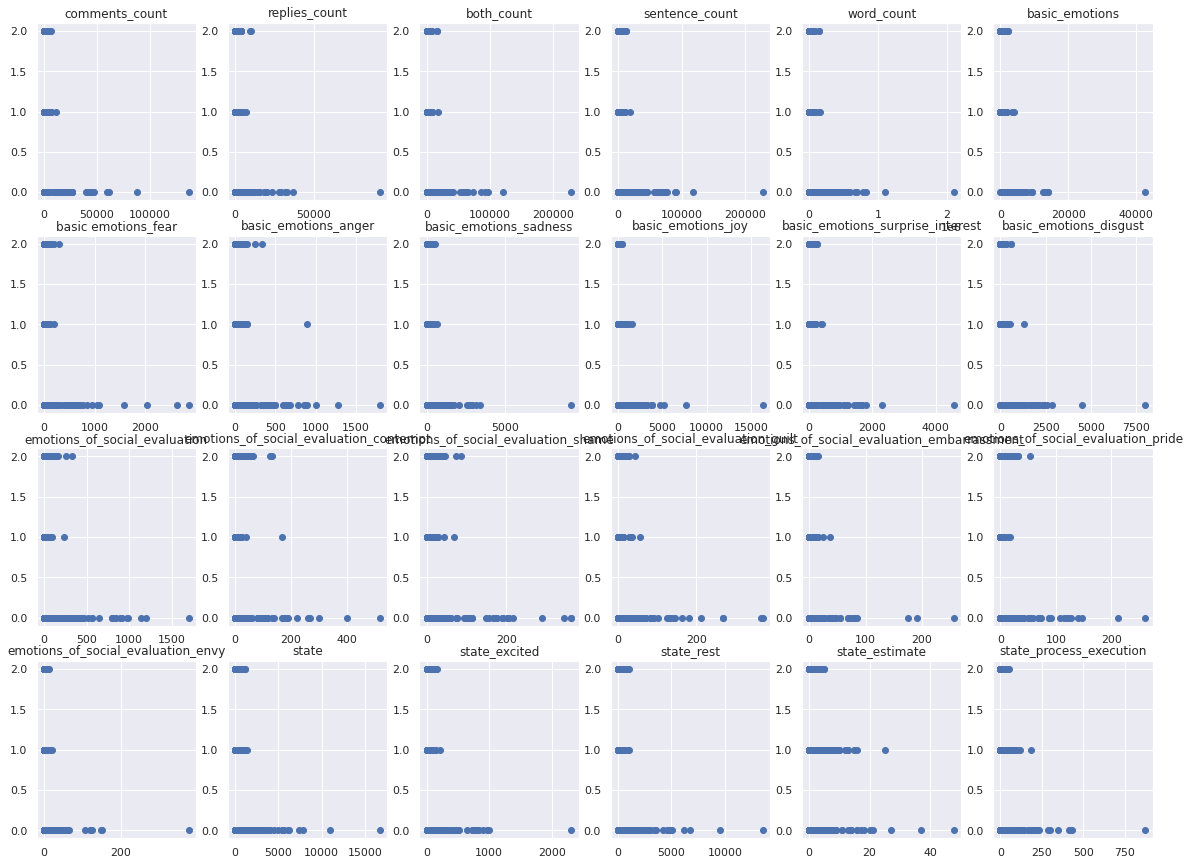

In [ ]:
fig, axes = plt.subplots(4, 6, figsize=(20, 15))
k = 0 

for i in train.drop(columns=['target']).columns:
    q, mod = divmod(k, 6)
    axes[q, mod].scatter(train[i], train['target'])
    axes[q, mod].set_title(i)
    k += 1

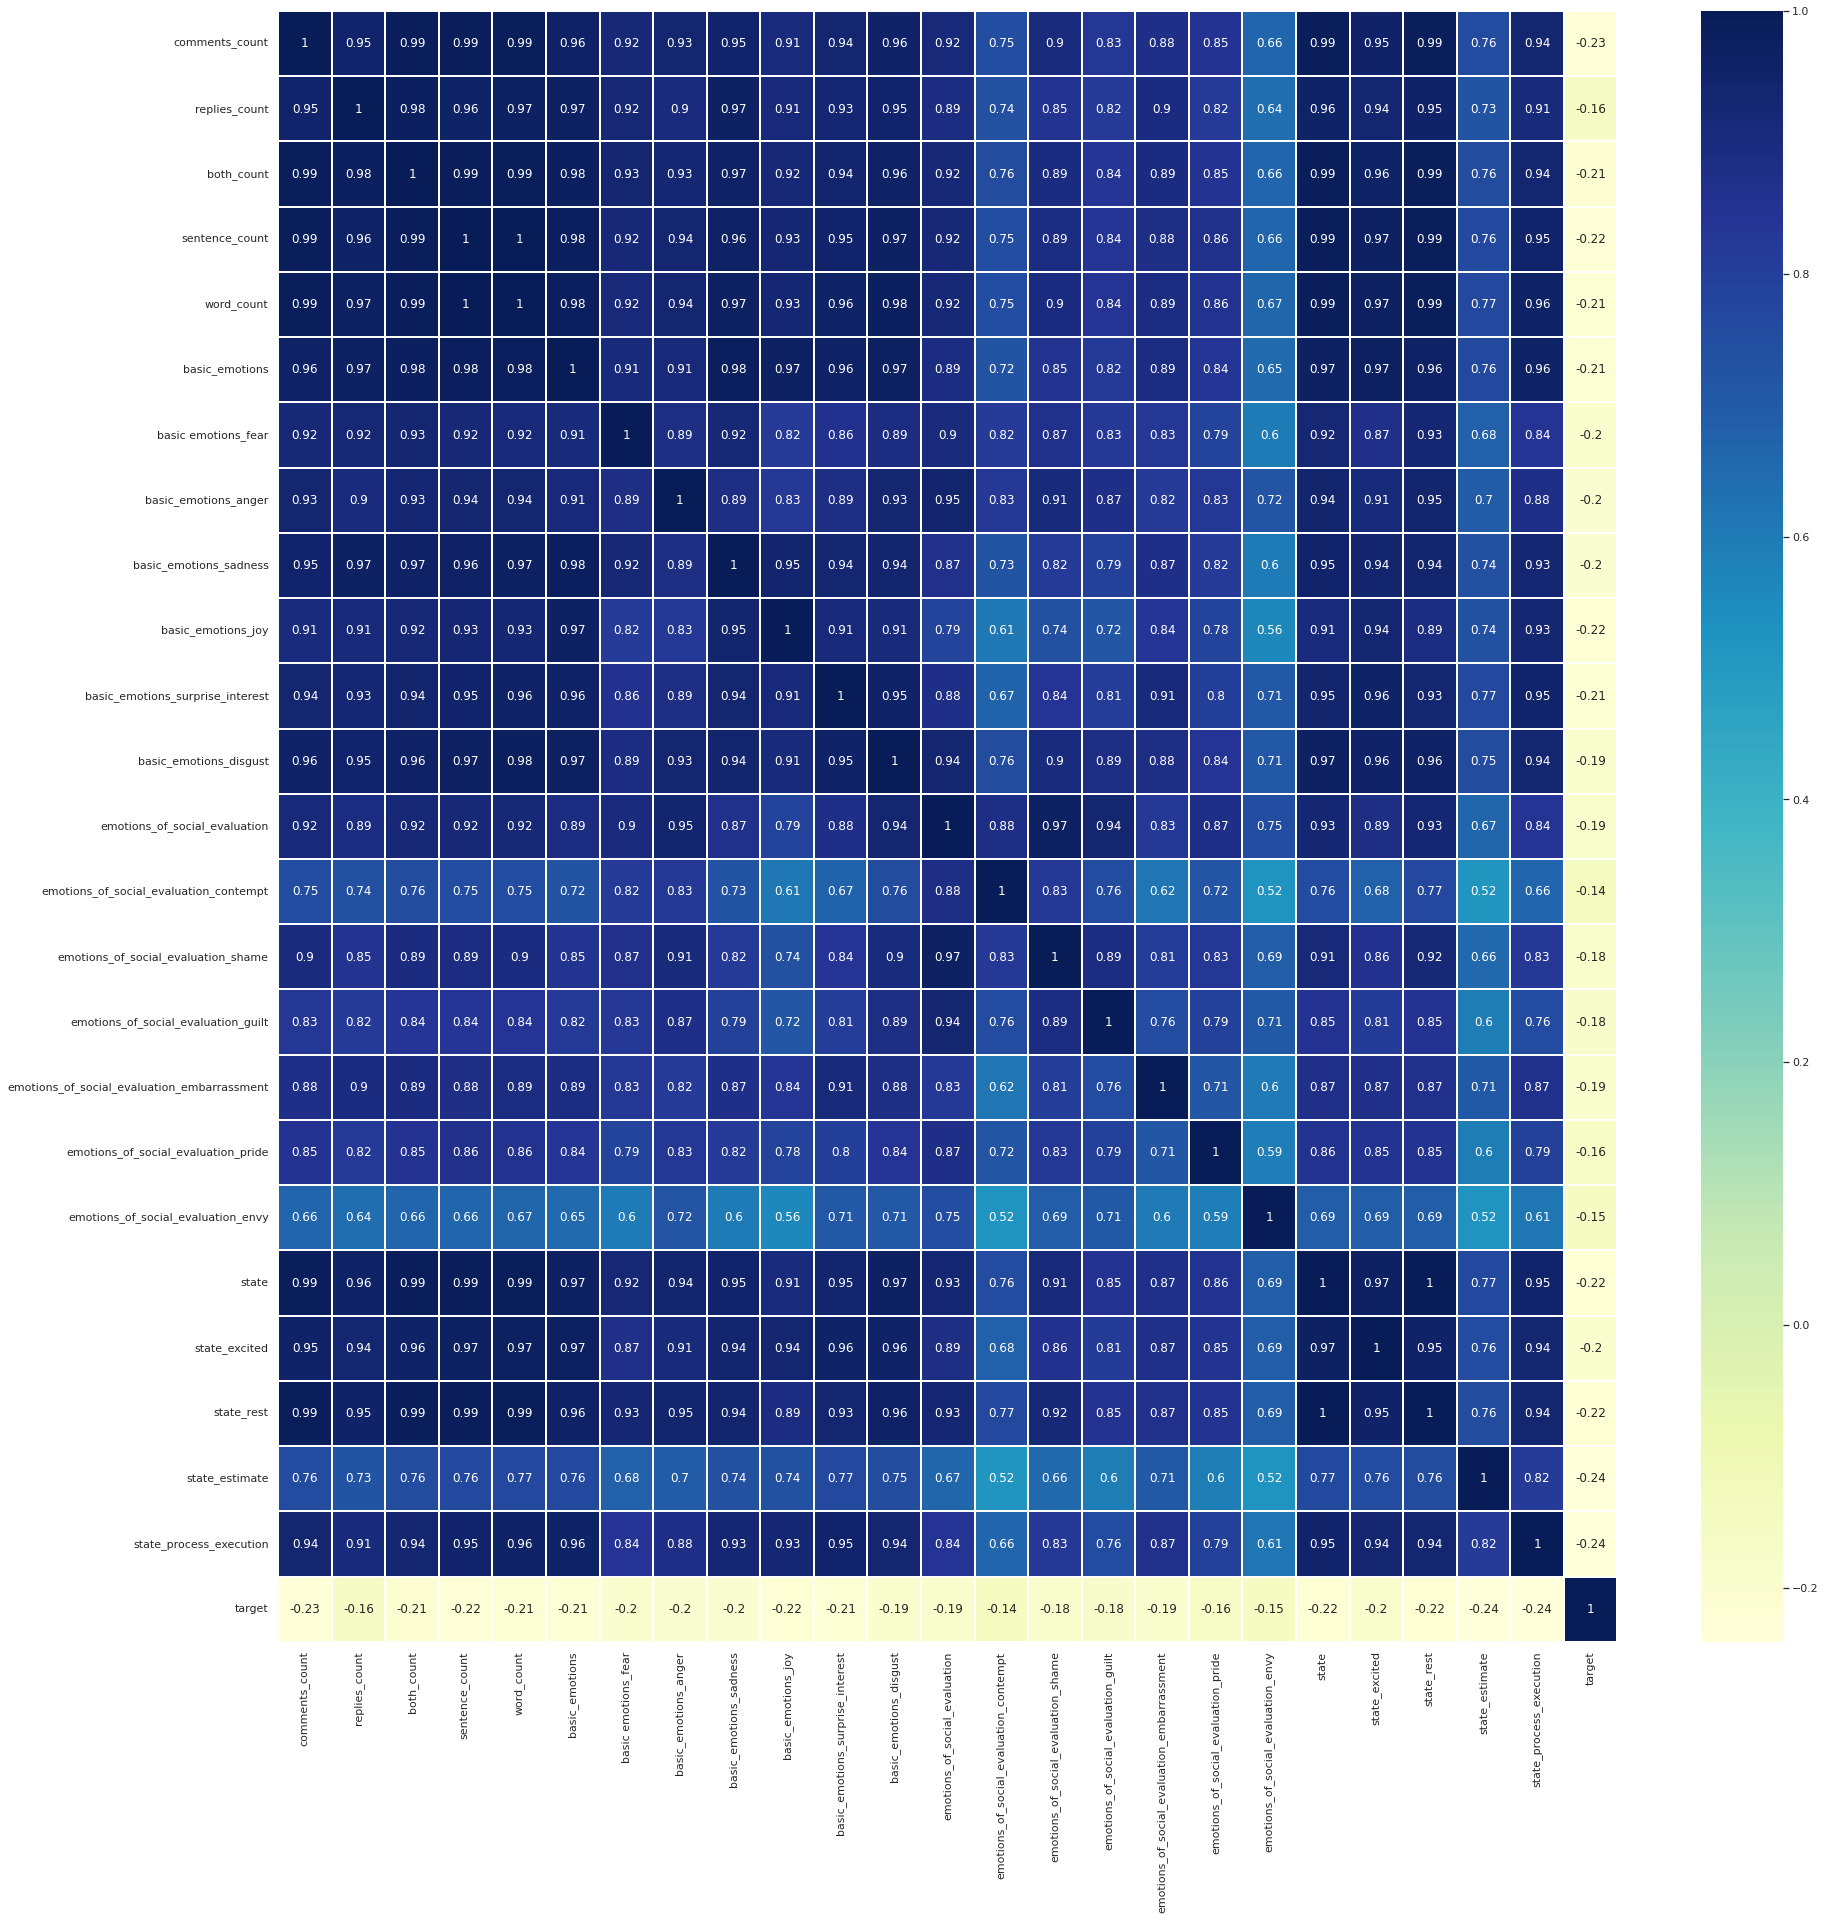

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(30,30)})

sns.heatmap(train.corr(), annot = True, cmap="YlGnBu", linecolor='white', linewidths=1)

### Пример отсутвия корреляции

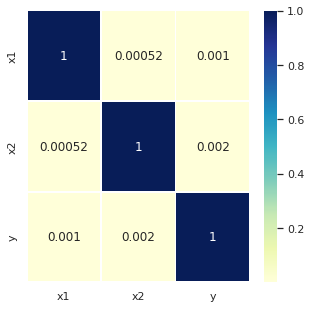

In [ ]:
from sklearn.datasets import make_circles
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

X,Y=make_circles(n_samples=500,noise=0.02)

x1, x2 = [], []

for i in X:
    x1.append(i[0])
    x2.append(i[1])

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': Y})

sns.set(rc = {'figure.figsize':(5,5)})

sns.heatmap(df.corr(), annot = True, cmap="YlGnBu", linecolor='white', linewidths=1)

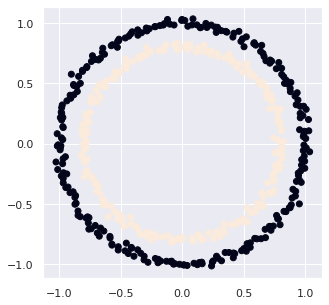

In [ ]:
plt.scatter(x1, x2, c=Y)
plt.show()

Несколько наборов точек (x, y) с коэффициентом корреляции Пирсона x и y для каждого набора. Корреляция отражает зашумленность и направление линейной зависимости (верхний ряд), но не наклон этой зависимости (в центре) и не многие аспекты нелинейной зависимости (внизу). NB: цифра в центре имеет наклон 0, но в этом случае коэффициент корреляции не определен, поскольку дисперсия Y равна нулю.

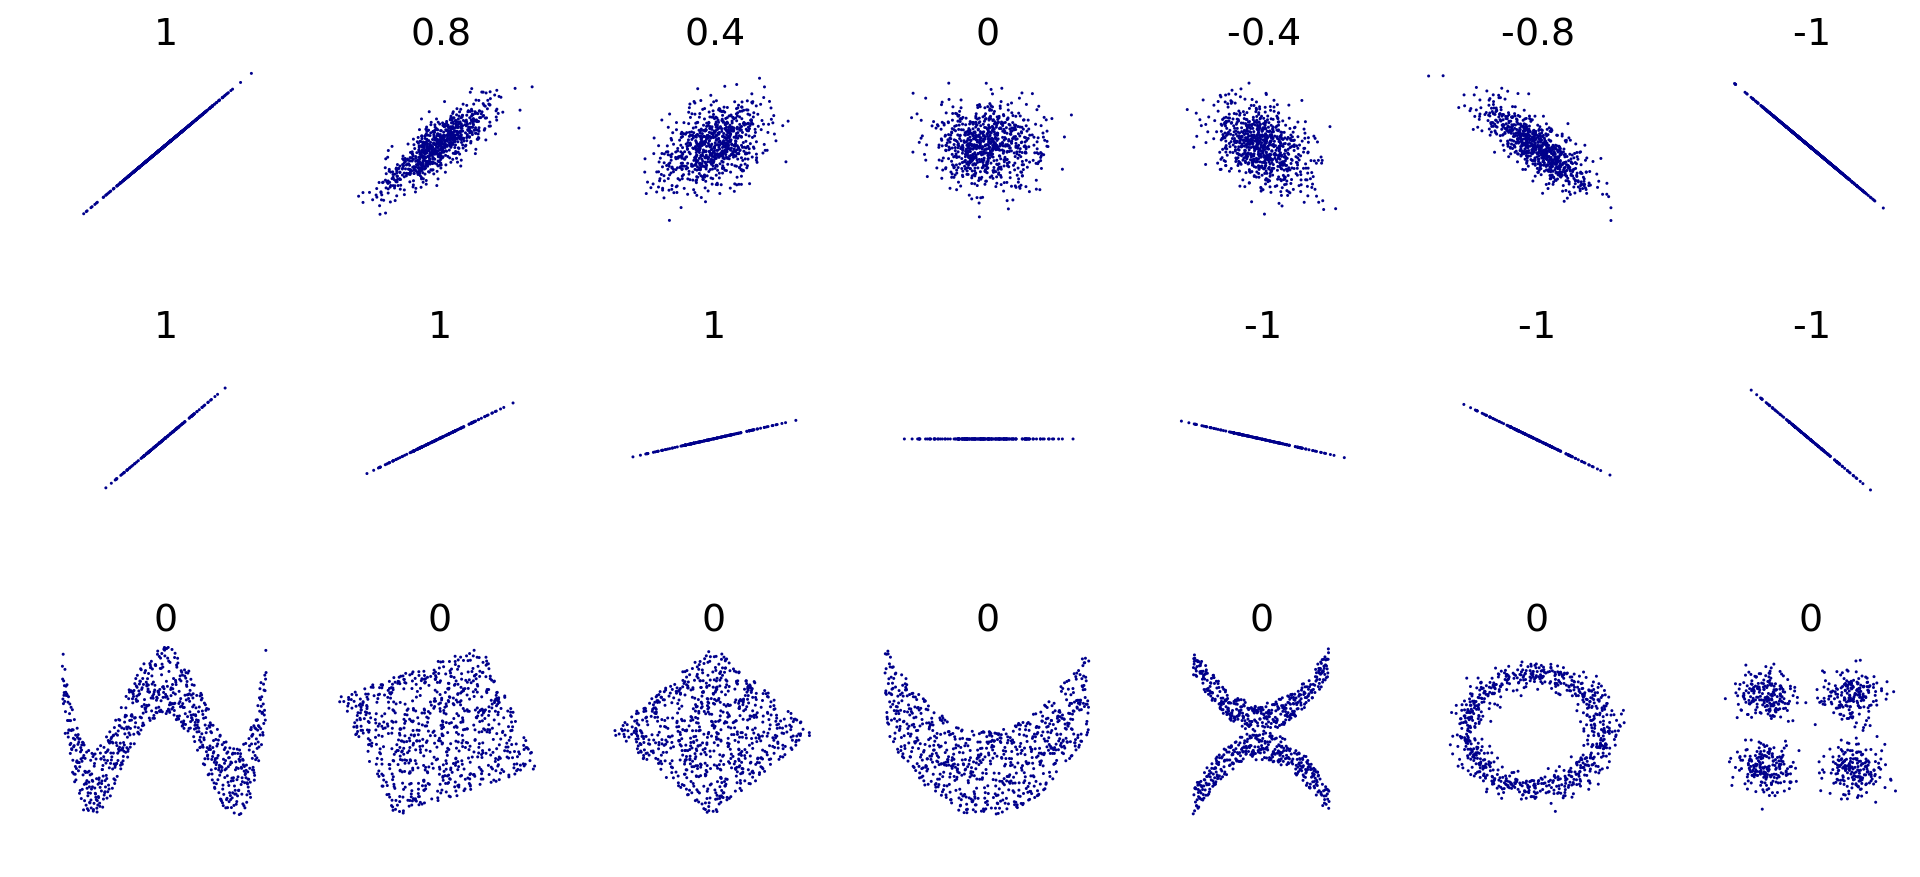

In [ ]:
train.groupby('target').agg(['count', 'mean', 'max', 'min', 'sum'])

comments_count                                   replies_count  \
                count         mean     max min      sum         count   
target                                                                  
0                 190  7193.852632  136877  11  1366832           190   
1                1540   410.258442   11432   0   631798          1540   
2                1651   256.362810    7056   0   423255          1651   

                                        ... state_estimate                    \
               mean    max min     sum  ...          count      mean max min   
target                                  ...                                    
0       3346.731579  91912   0  635879  ...            190  2.600000  48   0   
1        150.620130   6759   0  231955  ...           1540  0.472727  25   0   
2        271.552998   9787   0  448334  ...           1651  0.118716   5   0   

            state_process_execution                            
        sum                   count       mean  max min   sum  
target                                                         
0       494                     190  43.073684  874   0  8184  
1       728                    1540   4.834416  182   0  7445  
2       196                    1651   2.115687   51   0  3493  

[3 rows x 120 columns]

## Идем дальше

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(train.drop(columns=['target']))

X_test_std = scaler.transform(test)

df_X_std = pd.DataFrame(X_std, columns=train.drop(columns=['target']).columns)
df_X_std

,comments_count,replies_count,both_count,sentence_count,word_count,basic_emotions,basic emotions_fear,basic_emotions_anger,basic_emotions_sadness,basic_emotions_joy,...,emotions_of_social_evaluation_shame,emotions_of_social_evaluation_guilt,emotions_of_social_evaluation_embarrassment,emotions_of_social_evaluation_pride,emotions_of_social_evaluation_envy,state,state_excited,state_rest,state_estimate,state_process_execution
0,-0.131276,-0.072406,-0.112069,-0.099279,-0.066391,-0.071065,-0.091539,-0.053307,-0.042872,-0.136921,...,0.074828,-0.012002,0.112503,0.357826,-0.120771,-0.082464,0.007968,-0.086857,-0.223222,-0.212939
1,-0.095452,-0.113336,-0.102865,-0.103180,-0.102062,-0.105905,-0.111780,-0.173131,-0.068763,-0.104478,...,-0.156374,-0.149792,-0.016175,-0.059782,-0.008315,-0.101642,-0.112565,-0.098452,-0.223222,-0.099989
2,-0.145932,-0.163847,-0.153945,-0.149401,-0.155216,-0.148785,-0.142141,-0.188109,-0.146437,-0.129434,...,-0.156374,-0.149792,-0.144853,-0.164184,-0.120771,-0.141914,-0.172831,-0.133237,-0.223222,-0.175289
3,-0.121739,-0.131625,-0.126641,-0.125991,-0.136210,-0.138958,-0.132021,-0.158153,-0.142121,-0.134425,...,-0.156374,0.056893,-0.144853,-0.164184,-0.120771,-0.147668,-0.082432,-0.154108,-0.223222,-0.175289
4,-0.048229,-0.158186,-0.087526,-0.030998,-0.059799,0.031669,-0.132021,-0.113219,-0.129176,0.282333,...,-0.156374,-0.149792,-0.144853,-0.059782,-0.008315,-0.007673,-0.097498,-0.040477,7.760353,0.201213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,0.026444,-0.135979,-0.030464,0.060393,0.011041,0.164776,-0.081419,-0.143175,-0.116230,0.631711,...,-0.156374,-0.149792,-0.144853,-0.164184,-0.120771,0.207114,-0.112565,0.260992,-0.223222,0.125913
3377,-0.159657,-0.169508,-0.164989,-0.171011,-0.172600,-0.164865,-0.142141,-0.158153,-0.150752,-0.164372,...,-0.156374,-0.149792,-0.144853,-0.164184,-0.120771,-0.174516,-0.172831,-0.174979,-0.223222,-0.137639
3378,-0.150584,-0.165153,-0.157473,-0.156754,-0.157960,-0.156825,-0.142141,-0.143175,-0.133491,-0.166867,...,-0.098574,-0.080897,-0.144853,-0.164184,-0.120771,-0.176434,-0.172831,-0.172660,-0.223222,-0.212939
3379,-0.108014,-0.091129,-0.103325,-0.091325,-0.079107,-0.082678,-0.020696,-0.083263,-0.073079,-0.109469,...,-0.040773,-0.149792,-0.144853,-0.164184,-0.120771,-0.101642,-0.007099,-0.112366,-0.223222,-0.137639


In [ ]:
df_X_test_std = pd.DataFrame(X_test_std, columns=test.columns)
df_X_test_std

,comments_count,replies_count,both_count,sentence_count,word_count,basic_emotions,basic emotions_fear,basic_emotions_anger,basic_emotions_sadness,basic_emotions_joy,...,emotions_of_social_evaluation_shame,emotions_of_social_evaluation_guilt,emotions_of_social_evaluation_embarrassment,emotions_of_social_evaluation_pride,emotions_of_social_evaluation_envy,state,state_excited,state_rest,state_estimate,state_process_execution
0,-0.121041,-0.116820,-0.120965,-0.112635,-0.110829,-0.123772,-0.040937,-0.128197,-0.098970,-0.159381,...,-0.040773,-0.012002,-0.144853,-0.059782,-0.120771,-0.118902,-0.157765,-0.112366,-0.223222,-0.099989
1,-0.152910,-0.164282,-0.158700,-0.148351,-0.149779,-0.144319,-0.132021,-0.143175,-0.129176,-0.154389,...,-0.156374,-0.149792,-0.144853,-0.164184,-0.120771,-0.164927,-0.172831,-0.158746,-0.223222,-0.212939
2,-0.156400,-0.169508,-0.162841,-0.168309,-0.171613,-0.164865,-0.142141,-0.188109,-0.137806,-0.161876,...,-0.156374,-0.149792,-0.144853,-0.164184,-0.120771,-0.164927,-0.142698,-0.165703,-0.223222,-0.175289
3,-0.012171,-0.048457,-0.025096,0.018074,-0.006945,0.205869,-0.101660,-0.158153,-0.133491,0.761480,...,-0.098574,-0.149792,-0.144853,-0.164184,-0.120771,0.126569,-0.172831,0.177508,-0.223222,0.050612
4,-0.164077,-0.169508,-0.167903,-0.167859,-0.156856,-0.156825,-0.142141,-0.188109,-0.150752,-0.164372,...,-0.156374,-0.149792,-0.144853,-0.164184,-0.120771,-0.164927,-0.172831,-0.165703,-0.223222,-0.099989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,-0.152910,-0.169508,-0.160540,-0.163958,-0.168333,-0.161292,-0.132021,-0.158153,-0.150752,-0.149398,...,-0.156374,-0.149792,-0.144853,-0.164184,-0.120771,-0.166845,-0.172831,-0.161065,-0.223222,-0.212939
1445,-0.141279,-0.153396,-0.147195,-0.151352,-0.143940,-0.144319,-0.132021,-0.128197,-0.133491,-0.144407,...,-0.156374,-0.149792,-0.144853,0.044620,-0.120771,-0.139997,-0.142698,-0.137875,-0.223222,-0.137639
1446,-0.149421,-0.156009,-0.153484,-0.148801,-0.141965,-0.146999,-0.132021,-0.188109,-0.133491,-0.149398,...,-0.098574,-0.149792,-0.016175,-0.164184,-0.120771,-0.159174,-0.142698,-0.158746,-0.223222,-0.175289
1447,0.321415,-0.000124,0.211894,0.437362,0.227022,0.808871,-0.020696,-0.158153,0.423167,2.076639,...,-0.156374,-0.149792,-0.144853,-0.059782,0.104140,0.423819,0.038101,0.474339,0.309016,0.502415


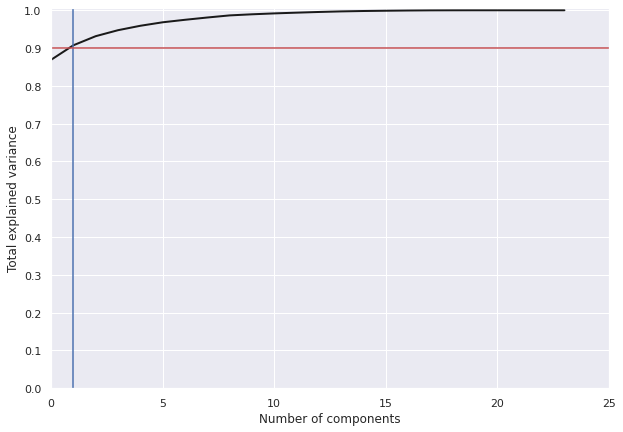

CPU times: user 358 ms, sys: 168 ms, total: 527 ms
Wall time: 372 ms


In [ ]:
%%time
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_X_std)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 25)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(1, c='b')
plt.axhline(0.9, c='r')
plt.show()

In [ ]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=15)

principalComponents = pca.fit_transform(df_X_std)

principalDf = pd.DataFrame(data = principalComponents)

CPU times: user 28.2 ms, sys: 27.2 ms, total: 55.4 ms
Wall time: 38.6 ms


In [ ]:
principalComponents_test = pca.transform(df_X_test_std)

principalDf_test = pd.DataFrame(data = principalComponents_test)

In [ ]:
principalDf.columns = ['f1', 'f2', 'f3', 'f4','f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15']
principalDf_test.columns = ['f1', 'f2', 'f3', 'f4','f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15']

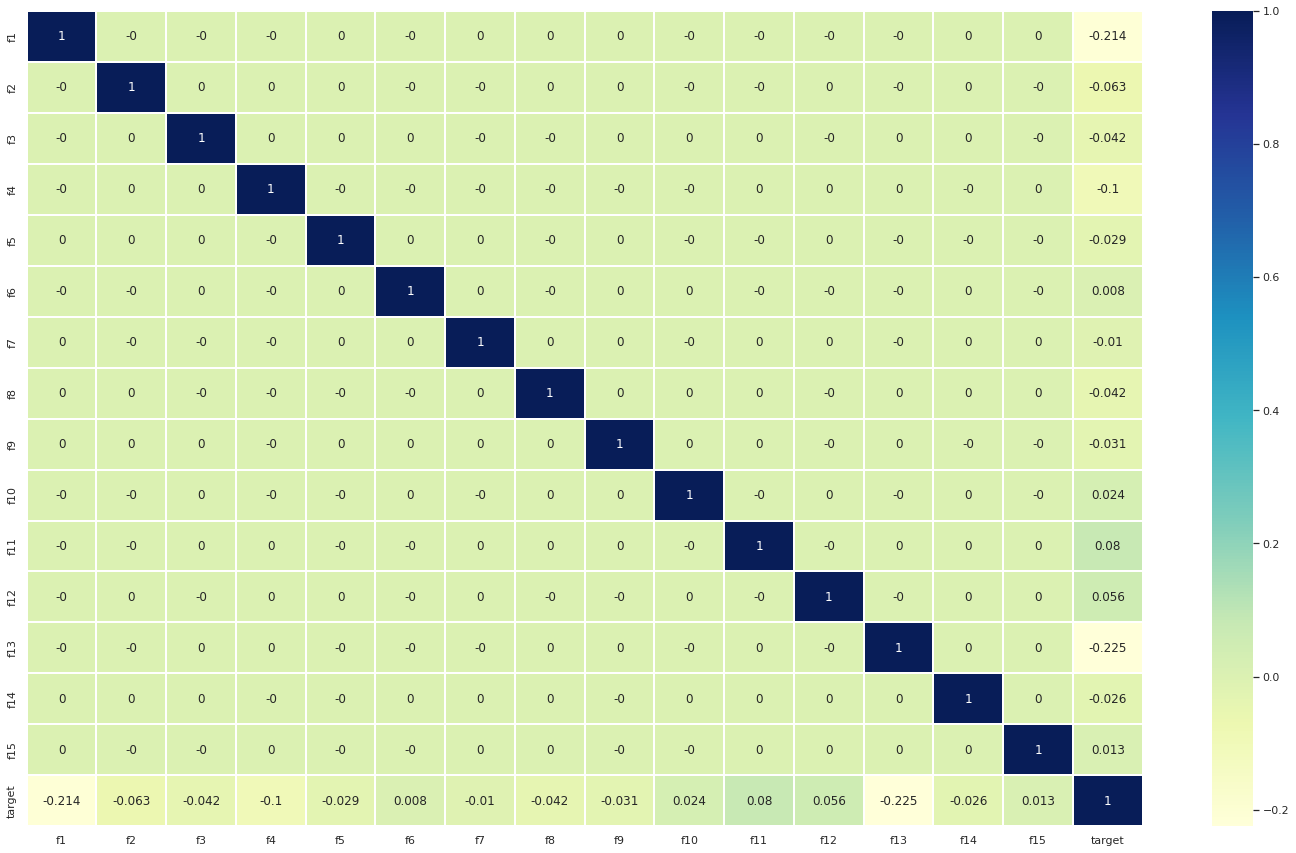

In [ ]:
principalDf['target'] = train['target']

sns.set(rc = {'figure.figsize':(25,15)})

sns.heatmap(principalDf.corr().round(3), annot = True, cmap="YlGnBu", linecolor='white', linewidths=1, fmt='g')

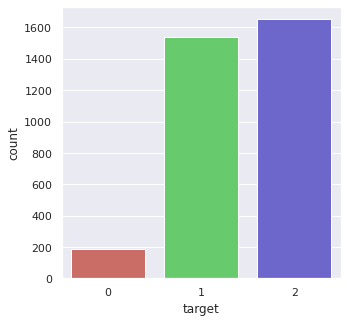

In [ ]:
sns.set(rc = {'figure.figsize':(5,5)})
y_data = pd.DataFrame(principalDf['target'])
sns.countplot(x='target', data=y_data, palette='hls')
plt.show()

In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(principalDf.drop(columns=['target']), principalDf['target'], test_size = 0.2, random_state = 0)

In [ ]:
%%time
# KNN
knn = KNeighborsClassifier(n_neighbors=13)

# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0, random_state=0) 

# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0, random_state=0) 

# instantiate classifier with sigmoid kernel and C=100.0
sigmoid_svc100=SVC(kernel='sigmoid', C=100.0, random_state=0) 

# random forest classifier with defult params
ram_tree = RandomForestClassifier(random_state=0)

xgbc = XGBClassifier(random_state=0)

models = [knn, poly_svc100, sigmoid_svc, sigmoid_svc100, ram_tree, xgbc]

results = {}
for model in models:
    # fit classifier to training set
    model.fit(X_train,y_train)

    # make predictions on test set
    y_pred = model.predict(X_test)

    model_scores = {'accuracy':accuracy_score(y_test, y_pred),
                    'confusion_matrix': confusion_matrix(y_test, y_pred)}
                
    results[str(model)] = model_scores

# 'precision': precision_score(y_test, y_pred),
# ' recall_score': recall_score(y_test, y_pred), 'f1_score': f1_score(y_test, y_pred)

CPU times: user 3.52 s, sys: 15.3 ms, total: 3.54 s
Wall time: 3.54 s


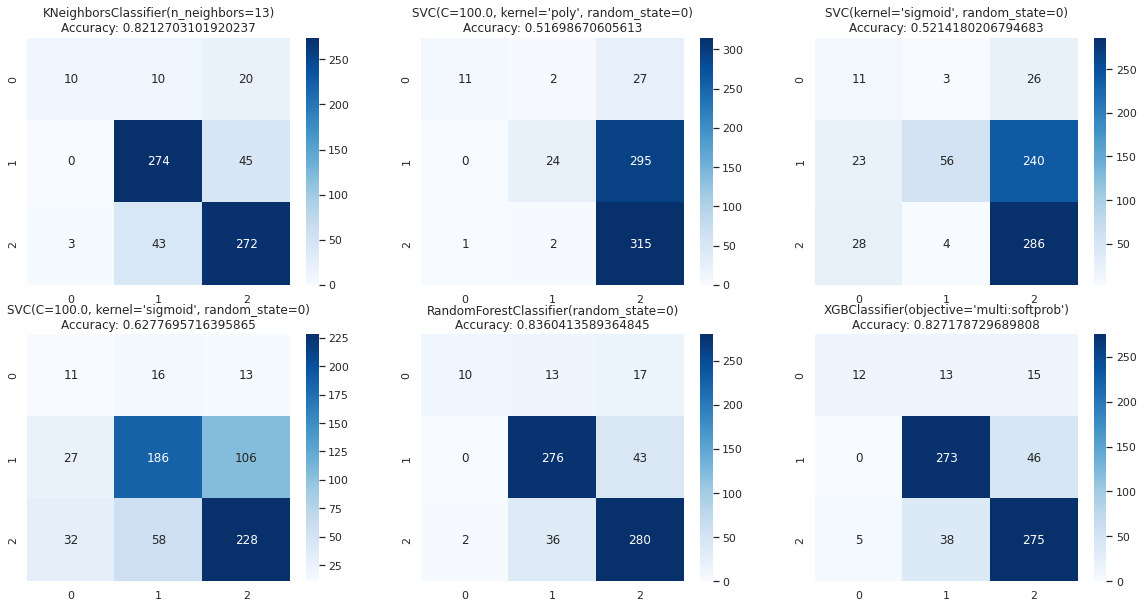

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20, 10))
k = 0 

for i in results:
    q, mod = divmod(k, 3)
    sns.heatmap(pd.DataFrame(results[i]['confusion_matrix']).astype('int32'), annot=True, ax=axes[q, mod], cmap=plt.cm.Blues, fmt='g')
    axes[q, mod].set_title(f"{i}\nAccuracy: {results[i]['accuracy']}")
    k += 1

0.8685376661742984


Text(0.5, 0, 'Random Forest Feature Importance')

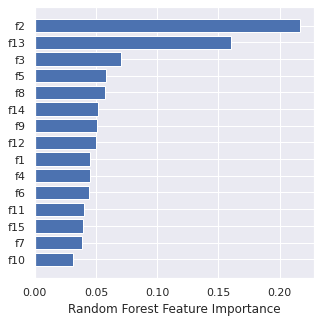

In [ ]:
rand_tree = RandomForestClassifier(random_state=0)

rand_tree.fit(X_train,y_train)
y_pred = rand_tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

sorted_idx = rand_tree.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rand_tree.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
xgbc = XGBClassifier(random_state=0)

xgbc.fit(X_train,y_train)
y_pred = xgbc.predict(X_test)
print(accuracy_score(y_test, y_pred))

y_pred_test = xgbc.predict(test)

0.8951255539143279


In [ ]:
submit = pd.DataFrame(y_pred_test, columns=['target'])
submit.to_csv('submit_2classes_without_pca.csv', index=False)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 19 kB/s 


In [ ]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()
catboost.fit(X_train,y_train)
y_pred = catboost.predict(X_test)
print(accuracy_score(y_test, y_pred))

# 0.90

In [ ]:
y_pred_test = catboost.predict(test)

In [ ]:
submit = pd.DataFrame(y_pred_test, columns=['target'])
submit.to_csv('submit_2classes_catboost.csv', index=False)

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

CV_rfc.best_params_

CPU times: user 11min 6s, sys: 2.13 s, total: 11min 8s
Wall time: 11min 17s


{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 200}

0.8596750369276218


Text(0.5, 0, 'Random Forest Feature Importance')

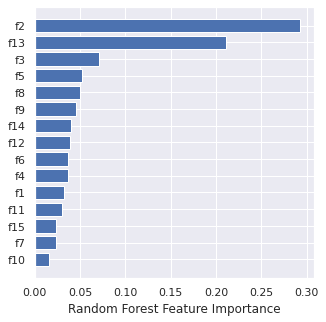

In [ ]:
rand_tree = RandomForestClassifier(criterion='gini', max_depth=7, max_features='auto', n_estimators=200, random_state=42)

rand_tree.fit(X_train,y_train)
y_pred = rand_tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

sorted_idx = rand_tree.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rand_tree.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# ТУТ УЖЕ ЭКСПЕРЕМЕНТЫ ПОШЛИ ПО ФИЧЕ ИНЖЕНИРИНГ

In [ ]:
# train
df_X_std_bs_em = df_X_std[['basic_emotions', 'basic emotions_fear', 'basic_emotions_anger',
                          'basic_emotions_sadness', 'basic_emotions_joy',
                          'basic_emotions_surprise_interest', 'basic_emotions_disgust']]

df_X_std_em_of_scl = df_X_std[['emotions_of_social_evaluation',
                              'emotions_of_social_evaluation_contempt',
                              'emotions_of_social_evaluation_shame',
                              'emotions_of_social_evaluation_guilt',
                              'emotions_of_social_evaluation_embarrassment',
                              'emotions_of_social_evaluation_pride',
                              'emotions_of_social_evaluation_envy']]

df_X_std_state = df_X_std[['state', 'state_excited', 'state_rest', 'state_estimate', 'state_process_execution']]

# test
df_X_test_std_bs_em = df_X_test_std[['basic_emotions', 'basic emotions_fear', 'basic_emotions_anger',
                          'basic_emotions_sadness', 'basic_emotions_joy',
                          'basic_emotions_surprise_interest', 'basic_emotions_disgust']]

df_X_test_std_em_of_scl = df_X_test_std[['emotions_of_social_evaluation',
                              'emotions_of_social_evaluation_contempt',
                              'emotions_of_social_evaluation_shame',
                              'emotions_of_social_evaluation_guilt',
                              'emotions_of_social_evaluation_embarrassment',
                              'emotions_of_social_evaluation_pride',
                              'emotions_of_social_evaluation_envy']]

df_X_test_std_state = df_X_test_std[['state', 'state_excited', 'state_rest', 'state_estimate', 'state_process_execution']]

# Train and Test PCA

# 1 basic_emotions
pca = PCA(n_components=1)
# train
principalComponents = pca.fit_transform(df_X_std_bs_em)
df_X_std_bs_em = pd.DataFrame(data = principalComponents)
# test
principalComponents_test = pca.fit_transform(df_X_test_std_bs_em)
df_X_test_std_bs_em = pd.DataFrame(data = principalComponents_test)


# 2 emotions_of_social_evaluation
pca = PCA(n_components=1)
# train
principalComponents = pca.fit_transform(df_X_std_em_of_scl)
df_X_std_em_of_scl = pd.DataFrame(data = principalComponents)
# test
principalComponents_test = pca.fit_transform(df_X_test_std_em_of_scl)
df_X_test_std_em_of_scl = pd.DataFrame(data = principalComponents_test)

# 3 state
pca = PCA(n_components=1)
# train
principalComponents = pca.fit_transform(df_X_std_state)
df_X_std_state = pd.DataFrame(data = principalComponents)
# test
principalComponents_test = pca.fit_transform(df_X_test_std_state)
df_X_test_std_state = pd.DataFrame(data = principalComponents_test)

res = pd.concat([df_X_std_bs_em,df_X_std_em_of_scl,df_X_std_state, train['target']], axis=1)
res.columns = ['basic_emotions_PCA', 'emotions_of_social_evaluation_PCA', 'state_PCA', 'target']

res_test = pd.concat([df_X_test_std_bs_em,df_X_test_std_em_of_scl,df_X_test_std_state], axis=1)
res_test.columns = ['basic_emotions_PCA', 'emotions_of_social_evaluation_PCA', 'state_PCA']

sns.set(rc = {'figure.figsize':(15,15)})

sns.heatmap(res.corr(), annot = True, cmap="YlGnBu", linecolor='white', linewidths=1)

In [ ]:
mean_basic = train[['basic_emotions', 'basic emotions_fear', 'basic_emotions_anger',
                          'basic_emotions_sadness', 'basic_emotions_joy',
                          'basic_emotions_surprise_interest', 'basic_emotions_disgust']].mean(axis=1)

mean_emotions = train[['emotions_of_social_evaluation',
                              'emotions_of_social_evaluation_contempt',
                              'emotions_of_social_evaluation_shame',
                              'emotions_of_social_evaluation_guilt',
                              'emotions_of_social_evaluation_embarrassment',
                              'emotions_of_social_evaluation_pride',
                              'emotions_of_social_evaluation_envy']].mean(axis=1)

mean_state = train[['state', 'state_excited', 'state_rest', 'state_estimate', 'state_process_execution']].mean(axis=1)

res2 = pd.concat([mean_basic, mean_emotions, mean_state, train.target], axis=1)
res2

,0,1,2,target
0,32.571429,4.000000,20.4,2
1,21.428571,0.857143,16.4,2
2,7.714286,0.000000,8.0,1
3,10.857143,0.857143,6.8,1
4,65.428571,0.571429,36.0,1
...,...,...,...,...
3376,108.000000,0.000000,80.8,1
3377,2.571429,0.000000,1.2,1
3378,5.142857,1.142857,0.8,2
3379,28.857143,0.857143,16.4,2


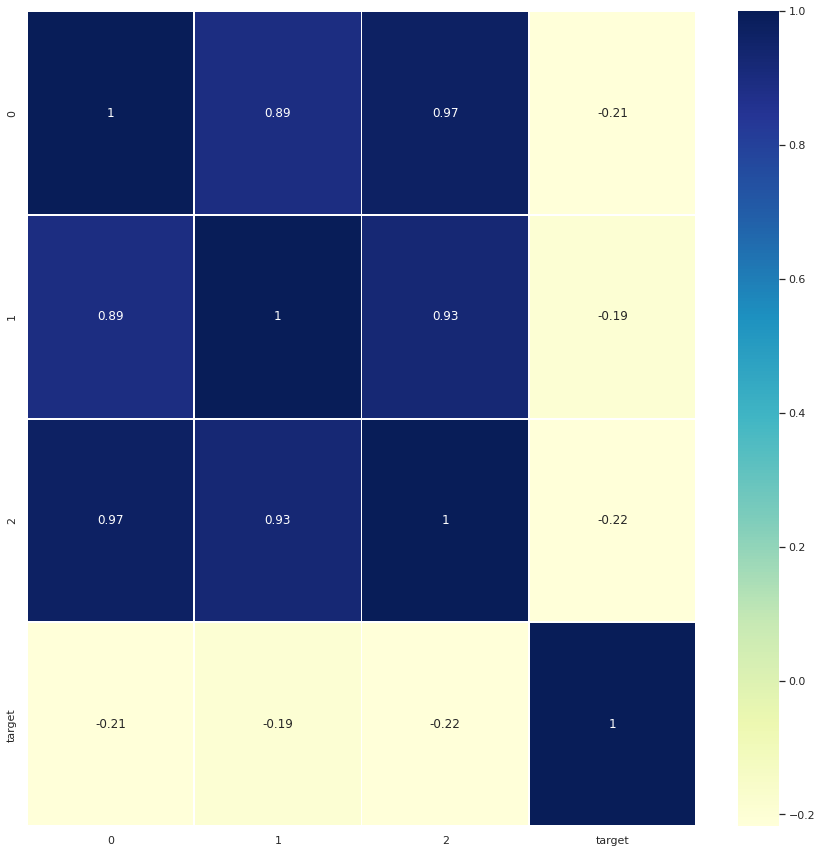

In [ ]:
sns.set(rc = {'figure.figsize':(15,15)})

sns.heatmap(res2.corr(), annot = True, cmap="YlGnBu", linecolor='white', linewidths=1)

The correlation between basic_emotions_PCA and the TARGET is -0.2122
Median value for loan that was not repaid = -0.3621
Median value for loan that was repaid =     0.0527
The correlation between emotions_of_social_evaluation_PCA and the TARGET is -0.1931
Median value for loan that was not repaid = -0.3240
Median value for loan that was repaid =     -0.0058
The correlation between state_PCA and the TARGET is -0.2323
Median value for loan that was not repaid = -0.3659
Median value for loan that was repaid =     0.0785


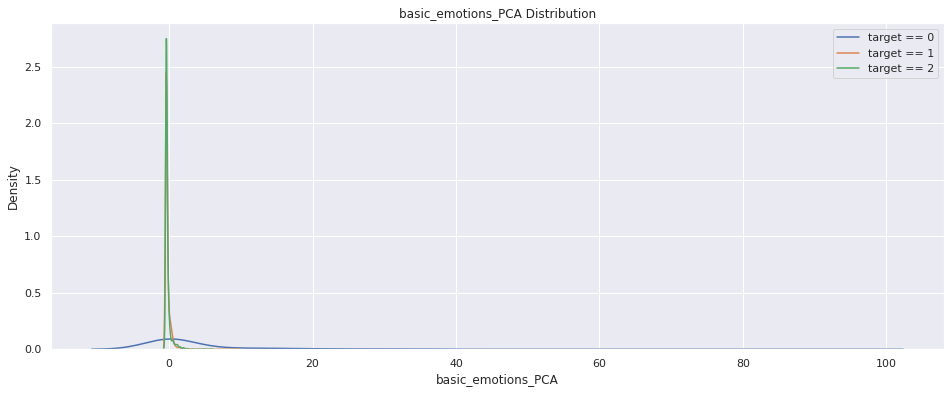

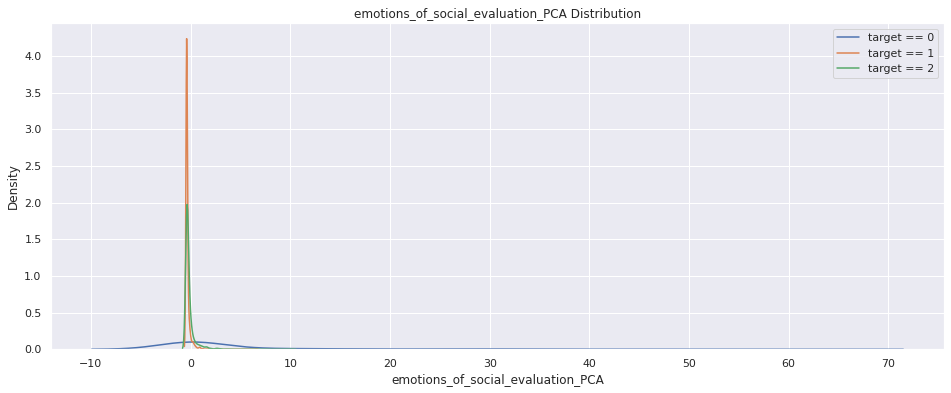

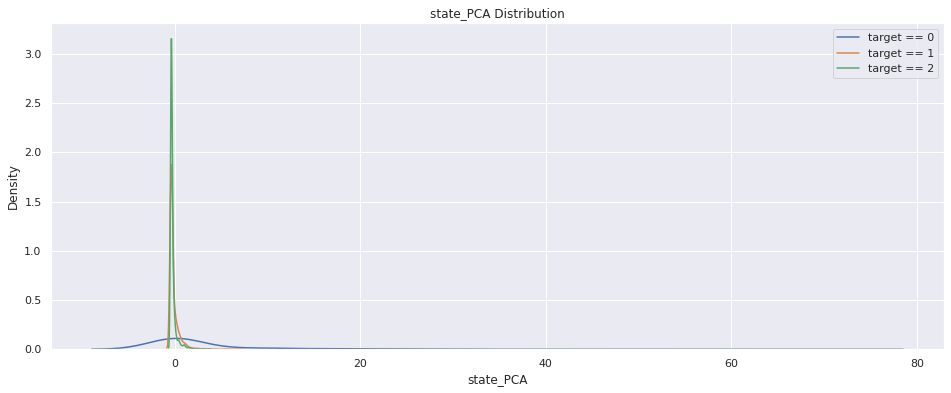

In [ ]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['target'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['target'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['target'] == 1, var_name].median()
    avg_not_repaid = df.loc[df['target'] == 2, var_name].median()
    
    plt.figure(figsize = (16, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['target'] == 0, var_name], label = 'target == 0')
    sns.kdeplot(df.loc[df['target'] == 1, var_name], label = 'target == 1')
    sns.kdeplot(df.loc[df['target'] == 2, var_name], label = 'target == 2')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)


kde_target('basic_emotions_PCA', res)
kde_target('emotions_of_social_evaluation_PCA', res)
kde_target('state_PCA', res)

In [ ]:
from imblearn.over_sampling import SMOTE

X = res.drop(columns=['target'])
y = res['target']

print("До балансировки данных")
print(X.shape)
print(y.value_counts())
print('-'*10)

os = SMOTE(random_state=0, k_neighbors=13)

column = X.columns

os_data_X, os_data_y = os.fit_resample(X, y)
os_data_X = pd.DataFrame(data=os_data_X, columns=column)
os_data_y = pd.DataFrame(data=os_data_y, columns=['target'])

print("После балансировки")
print(os_data_X.shape)
print(os_data_y.value_counts())

До балансировки данных
(3381, 3)
2    1651
1    1540
0     190
Name: target, dtype: int64
----------
После балансировки
(4953, 3)
target
0         1651
1         1651
2         1651
dtype: int64
